In [1]:
from calitp.tables import tbl
from siuba import *
from siuba.sql import sql_raw
from siuba.experimental import completer
from plotnine import *

In [2]:
from siuba.dply.verbs import singledispatch2
from siuba.sql import LazyTbl

DATE_START = "2021-01-01"
DATE_END = "2021-07-20"


@singledispatch2(LazyTbl)
def cross_by_date(__data, expr_date_filter):
    tbl_dates = tbl.views.dim_date() >> filter(expr_date_filter) >> select(_.full_date)
    return inner_join(
        __data >> mutate(calitp_deleted_at=_.calitp_deleted_at.fillna("2099-01-01")),
        tbl_dates,
        sql_on=lambda lhs, rhs: (lhs.calitp_extracted_at <= rhs.full_date)
        & (lhs.calitp_deleted_at > rhs.full_date),
    )


scale_date_weekly = scale_x_date(date_breaks="1 weeks")
scale_date_monthly = scale_x_date(date_breaks="1 months")

enrich_name = inner_join(
    _, tbl.views.gtfs_agency_names(), ["calitp_itp_id", "calitp_url_number"]
) >> select(_.agency_name, _.calitp_itp_id, _.calitp_url_number, _.contains(""))

## Are Feed Expiration dates meaningful and reliable?

In [3]:
DATE_YEAR_AGO = "2020-07-14"
DATE_YEAR_OUT = "2022-07-12"
TODAY_DATE = "2020-07-15"
DATE_MONTH_AGO = "2020-06-15"

# TODO: should not hard code DATE_YEAR_AGO, since depends on date today
tbl_feed_info = (tbl.gtfs_schedule.feed_info()                   
     >> mutate(
         start_date = sql_raw('PARSE_DATE("%Y%m%d", feed_start_date)'),
         end_date = sql_raw('PARSE_DATE("%Y%m%d", feed_end_date)'),
         start_date_year_ago = _.start_date < DATE_YEAR_AGO,
         end_date_year_out = _.end_date > DATE_YEAR_OUT,
         date_diff_days=sql_raw("DATE_DIFF(end_date, start_date, DAY)"),
         date_diff_btn_year = _.date_diff_days < 365,
         
         start_date_btn_month = (_.start_date > DATE_MONTH_AGO) & (_.start_date < TODAY_DATE),
         end_date_btn_month = (_.end_date > DATE_MONTH_AGO) & (_.end_date < TODAY_DATE)
     )
    >> enrich_name
)

In [4]:
tbl_expiration = (
    tbl_feed_info
    >> mutate(end_date_max=_.end_date.max(), start_date_min=_.start_date)
    >> summarize(
        start_date_min=_.start_date_min.min(),
        end_date_max=_.end_date_max.max(),
        n_start_date_min=(_.start_date == _.start_date_min).astype(int).sum(),
        n_end_date_max = (_.end_date == _.end_date_max).astype(int).sum(),
        #n_start_date_min=(_.end_date == _.end_date_max).astype(int).sum(),
        n_start_date_year=(_.start_date < DATE_YEAR_AGO).astype(int).sum(),
        n_end_date_year=(_.end_date > DATE_YEAR_OUT).astype(int).sum(),
        avg_date_diff=_.date_diff_days.mean().round(),
        n_date_diff_btn_year = _.date_diff_btn_year.astype(int).sum(),
        
        n_start_date_btn_month = _.start_date_btn_month.astype(int).sum(),
        n_end_date_btn_month = _.end_date_btn_month.astype(int).sum(),
    
    )
 
)

In [5]:
tbl_expiration >> collect() >> pipe(_.melt())

,variable,value
0,start_date_min,2012-02-01
1,end_date_max,2029-12-31
2,n_start_date_min,153
3,n_end_date_max,1
4,n_start_date_year,17
5,n_end_date_year,8
6,avg_date_diff,346
7,n_date_diff_btn_year,109
8,n_start_date_btn_month,4
9,n_end_date_btn_month,0


* **What is the furthest future date in feed_info_end?** `2029-12-31`
* **How many feeds share this furthest feed_into_end date?** `One`

* **What is the oldest feed_start_date?** `2012-02-01`
* **How many feeds share this feed_start date?** `Two`

* **How Many feeds have a feed_info_end_date more than one year into the future?** `8`
* **How many feeds have a feed_start_date that is more than one year in the future?** `19`

* **What is the average length of time between a feed_info_start and feed_info_end?** `327 Days`
* **How many feeds have one year or less between feed_info_start and feed_info_end?** `130`


### Scratchpad

In [6]:
tbl_feed_info

,agency_name,calitp_itp_id,calitp_url_number,feed_publisher_name,feed_publisher_url,feed_lang,default_lang,feed_start_date,feed_end_date,feed_version,...,feed_contact_url,calitp_extracted_at,start_date,end_date,start_date_year_ago,end_date_year_out,date_diff_days,date_diff_btn_year,start_date_btn_month,end_date_btn_month
0,MVGO,217,0,"Trillium Solutions, Inc.",http://www.trilliumtransit.com,en,None,20210708,20220101,UTC: 08-Jul-2021 19:41,...,http://support.trilliumtransit.com,2021-07-08,2021-07-08,2022-01-01,False,False,177.0,True,False,False
1,Metro,182,0,Los Angeles County Metropolitan Transportation...,https://www.metro.net,en,None,None,None,None,...,http://developer.metro.net,2021-07-18,None,None,None,None,NaN,None,None,None
2,Metro,182,1,Los Angeles County Metropolitan Transportation...,https://www.metro.net,en,None,None,None,None,...,http://developer.metro.net,2021-07-17,None,None,None,None,NaN,None,None,None
3,GTrans,118,0,"Trillium Solutions, Inc.",http://www.trilliumtransit.com,en,None,20210623,20211017,UTC: 23-Jun-2021 20:13,...,http://support.trilliumtransit.com,2021-06-23,2021-06-23,2021-10-17,False,False,116.0,True,False,False
4,WestCAT,368,0,"Trillium Solutions, Inc.",http://www.trilliumtransit.com,en,None,20210617,20211001,UTC: 17-Jun-2021 16:16,...,http://support.trilliumtransit.com,2021-06-17,2021-06-17,2021-10-01,False,False,106.0,True,False,False


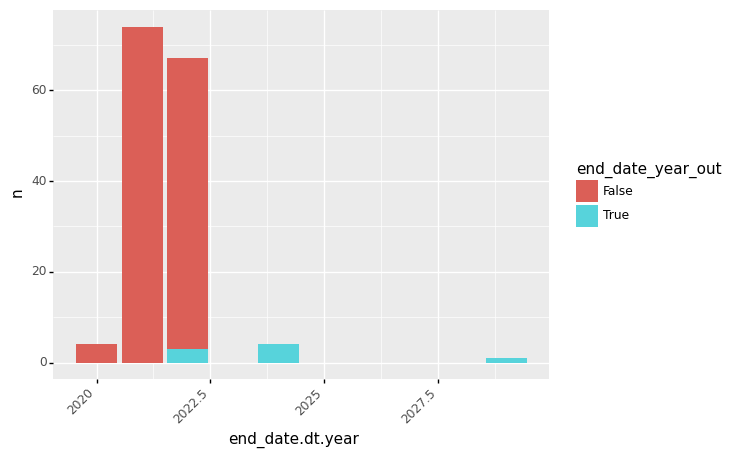

<ggplot: (276362207)>

In [7]:
# plot end date counts using tbl_feed_info 
(
    tbl_feed_info 
    >> collect()
    >> filter(_.end_date.notna())
    >> mutate(end_date = _.end_date.astype("datetime64[ns]"), n = 1)
    >> ggplot(aes("end_date.dt.year", "n", fill="end_date_year_out")) + geom_col() + theme(axis_text_x = element_text(angle=45, hjust=1))
)
#missing years are not plotted

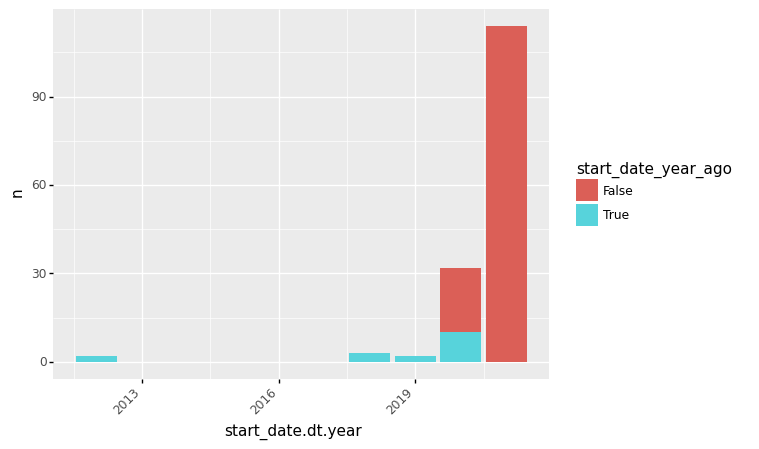

<ggplot: (274504439)>

In [8]:
# plot start date counts using tbl_feed_info 
(
    tbl_feed_info 
    >> collect()
    >> filter(_.start_date.notna())
    >> mutate(start_date = _.start_date.astype("datetime64[ns]"), n = 1)
    >> ggplot(aes("start_date.dt.year", "n", fill="start_date_year_ago")) + geom_col() + theme(axis_text_x = element_text(angle=45, hjust=1))
)
#missing years are not plotted

## How many agencies have invalid GTFS Data? 

In [9]:
tbl_feed_info_daily = (
    tbl.gtfs_schedule_type2.feed_info()
    >> mutate(deleted_at=_.calitp_deleted_at.fillna("2099-01-01"))
    >> cross_by_date(_.full_date.between(DATE_START, DATE_END))
    >> mutate(
        start_date=sql_raw('PARSE_DATE("%Y%m%d", feed_start_date)'),
        end_date=sql_raw('PARSE_DATE("%Y%m%d", feed_end_date)'),
        date_start_future=(_.start_date > _.full_date).astype(int),
        date_end_past=(_.end_date < _.full_date).astype(int),
        date_diff_days=sql_raw("DATE_DIFF(end_date, start_date, DAY)"),
        date_diff_short=_.date_diff_days < 365,
    )
    >> enrich_name
)

# has feed info for every feed, for every day in the past month
tbl_feed_info_daily_agg = (
    tbl_feed_info_daily
    >> group_by(_.full_date)
    >> summarize(
        avg_date_diff=_.date_diff_days.mean(),
        n_start_future=_.date_start_future.sum(),
        n_end_past=_.date_end_past.sum(),
        pct_start_future=_.date_start_future.mean(),
        pct_end_past=_.date_end_past.mean(),
    )
    >> collect()
)

In [10]:
tbl_calendar_info = (
    tbl.gtfs_schedule_type2.calendar()
    >> cross_by_date(_.full_date.between(DATE_START, DATE_END))
    >> mutate(
        calendar_start_date=sql_raw('PARSE_DATE("%Y%m%d", start_date)'),
        calendar_end_date=sql_raw('PARSE_DATE("%Y%m%d", end_date)'),
        calendar_start_date_future=_.calendar_start_date > _.full_date,
        calendar_end_date_past=_.calendar_end_date < _.full_date,
    )
)

tbl_calendar_feed_expiration = (
    tbl_calendar_info
    >> mutate(
        calendar_end_date_max=_.calendar_end_date.max(),
        calendar_start_date_min=_.calendar_start_date.min(),
    )
    >> enrich_name
    >> group_by(_.full_date, _.calitp_itp_id, _.calitp_url_number)  # grouping by feed
    >> summarize(
        end_date_max=_.calendar_end_date_max.max(),
        start_date_min=_.calendar_start_date_min.min(),
        pct_start_date_future=(_.calendar_start_date_future).astype(int).mean(),
        pct_end_date_past=(_.calendar_end_date_past).astype(int).mean(),
    )
)

tbl_calendar_expiration = (
    tbl_calendar_feed_expiration
    >> group_by(_.full_date)
    >> summarize(
        n_start_date_future=(_.pct_start_date_future == 1).astype(int).sum(),
        n_end_date_past=(_.pct_end_date_past == 1).astype(int).sum(),
    )
)

### Feed info related

* **For each day in the past month, how many agencies had a feed_end_date in the past?**
* **For each day in the past month, how many agencies had a feed_start_date in the future?** 

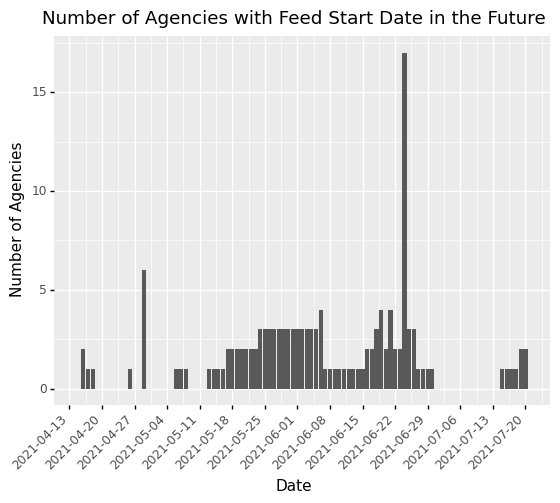

<ggplot: (306255604)>

In [11]:
(
    tbl_feed_info_daily_agg
    >> ggplot(aes("full_date", "n_start_future"))
    + geom_col()
    + labs(y="Number of Agencies", x="Date")
    + scale_x_datetime(date_breaks="1 weeks")
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + ggtitle("Number of Agencies with Feed Start Date in the Future")
)

### Calendar related

* **For how many feeds are all end_dates in the past?**
* **For how many feeds are all start_dates in the future?**

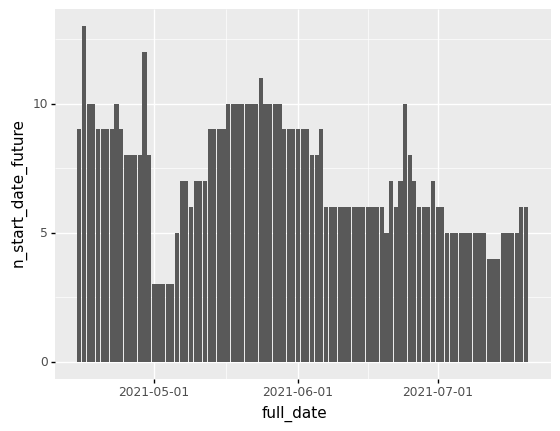

<ggplot: (305920278)>

In [12]:
(
    tbl_calendar_expiration
    >> collect()
    >> ggplot(aes("full_date", "n_start_date_future")) + geom_col() + scale_date_monthly
)

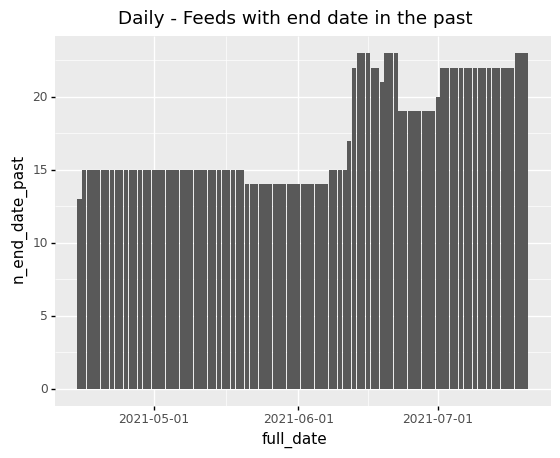

<ggplot: (306431717)>

In [13]:
# TODO: this calculation is likely distorted by old feeds that are no longer used
# e.g. agencies.yml removed the feed.
# we'll keep it in our history, so likely need to filter to keep only current
# feed entries.
(
    tbl_calendar_expiration
    >> collect()
    >> mutate(full_date = _.full_date.astype("datetime64[ns]"))
    >> ggplot(aes("full_date", "n_end_date_past")) + geom_col() + scale_date_monthly
    + labs(title = "Daily - Feeds with end date in the past")
)

## How "good" is California transit data? (TODO: calculate on metabase)



* **How many feeds (as a percentage) have zero validation errors?** `25`
* **What is the average number of unique errors per feed?** ``
* **How many feeds are invalid?**


* **How many routes are supported by GTFS feeds?**
* **How many unique agency ids are supported by GTFS feeds?**

## What errors are common on a vendor's feeds?

* What are all the unique errors ~~for each of~~ **across** a vendor’s clients?
* What percent of all feeds have each of these errors? (How common are they?)

NOTE: vendor here defined using feed_info.feed_publisher_name

In [14]:
_tbl_vendor_history = (
    tbl.gtfs_schedule_type2.feed_info()
    >> cross_by_date(_.full_date.between(DATE_START, DATE_END))
    >> select(_.calitp_itp_id, _.calitp_url_number, _.full_date, _.feed_publisher_name)
)

_tbl_validation_code_history = (
    tbl.gtfs_schedule_type2.validation_notices()
    >> cross_by_date(_.full_date.between(DATE_START, DATE_END))
    >> count(_.calitp_itp_id, _.calitp_url_number, _.full_date, _.code, _.severity)
)

tbl_vendor_code_history = (
    _tbl_validation_code_history
    >> left_join(
        _, _tbl_vendor_history, ["calitp_itp_id", "calitp_url_number", "full_date"],
    )
    >> enrich_name
)


# Drill down tables --------

#

tbl_vendor_code_counts = tbl_vendor_code_history >> count(
    _.feed_publisher_name, _.full_date, _.code, _.severity
)

tbl_vendor_daily_metrics = tbl_vendor_code_counts >> count(
    _.feed_publisher_name, _.full_date, _.severity
)

# What percent of all feeds have each of these errors?

_tbl_daily_feed_count = (
    _tbl_vendor_history >> count(_.full_date) >> rename(ttl_feeds="n")
)

tbl_code_metrics = (
    tbl_vendor_code_history
    >> distinct(_.calitp_itp_id, _.calitp_url_number, _.full_date, _.code, _.severity)
    >> count(_.code, _.severity, _.full_date)
    >> rename(n_feeds_with_code="n")
    >> left_join(_, _tbl_daily_feed_count, "full_date")
    >> mutate(pct_feeds_with_code=_.n_feeds_with_code / _.ttl_feeds)
)

### Unique errors across a vendor's clients

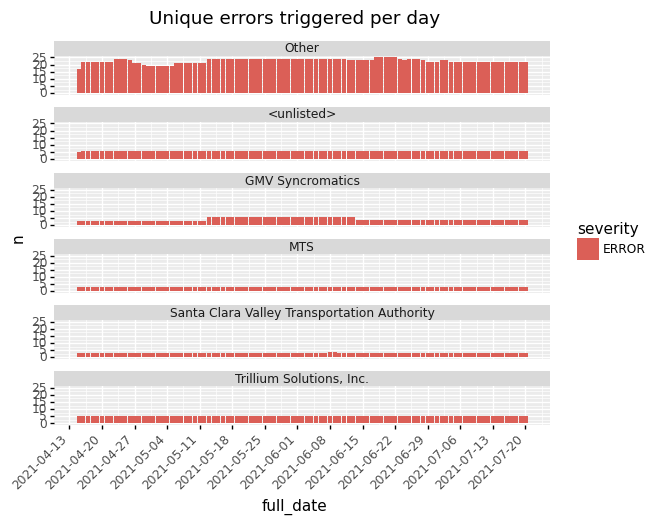

<ggplot: (306069688)>

In [15]:
# Count of trillium unique errors triggered per day
from siuba.dply.forcats import fct_lump

(
    tbl_vendor_daily_metrics
    >> filter(_.severity == "ERROR")
    >> collect()
    >> mutate(feed_publisher_name = fct_lump(_.feed_publisher_name.fillna("<unlisted>"), n = 5, w = _.n))    
    >> ggplot(aes("full_date", "n", fill="severity"))
     + geom_col()
    + scale_x_date(date_breaks="1 weeks")
    + theme(axis_text_x=element_text(angle=45, hjust=1))    
    + labs(title="Unique errors triggered per day")
    + facet_wrap("~feed_publisher_name", ncol=1)
)

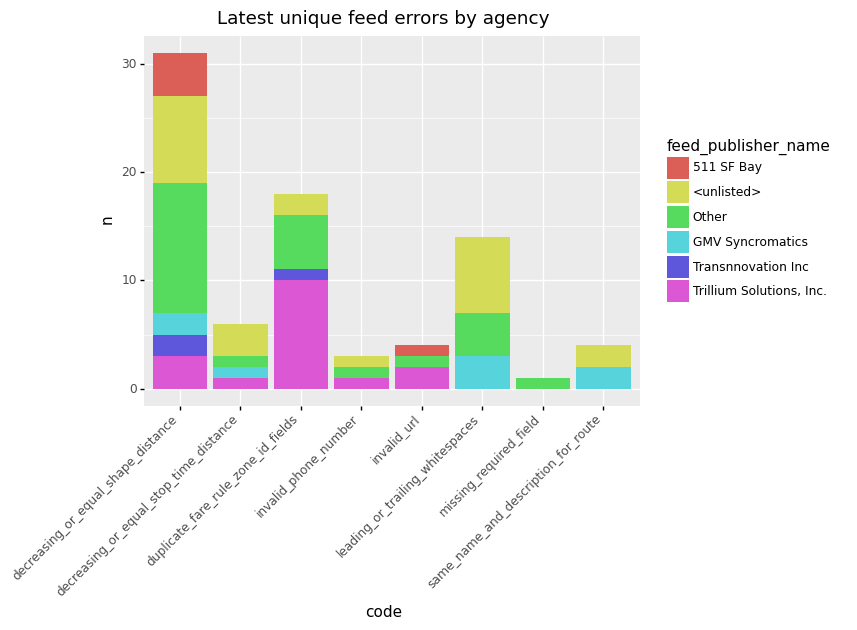

<ggplot: (306313578)>

In [16]:
(
    tbl_vendor_code_counts
    >> filter(_.severity == "ERROR", _.full_date == _.full_date.max())
    >> collect()
    >> mutate(feed_publisher_name = fct_lump(_.feed_publisher_name.fillna("<unlisted>"), n = 5, w = _.n))    
    >> ggplot(aes("code", "n", fill="feed_publisher_name"))
     + geom_col()
    + theme(axis_text_x=element_text(angle=45, hjust=1))    
    + labs(title="Latest unique feed errors by agency")
)

### What percent of all feeds have each of these errors? (How common are they?)

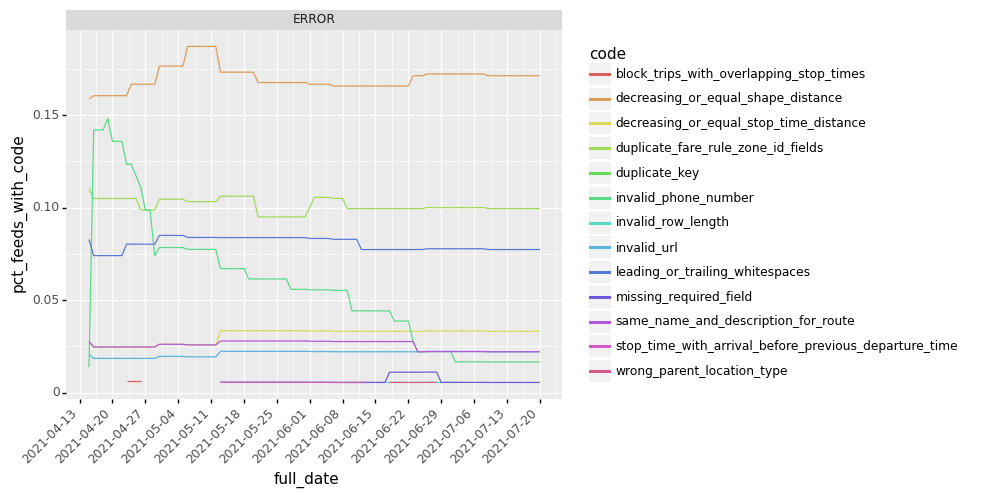

<ggplot: (307328485)>

In [17]:
(
    tbl_code_metrics
    >> collect()
    >> filter(_.severity == "ERROR")
    >> ggplot(aes("full_date", "pct_feeds_with_code", color="code", group="code"))
    + geom_line()
    + facet_wrap("~severity", ncol=1)
    + scale_x_date(date_breaks="1 weeks")
    + theme(axis_text_x=element_text(angle=45, hjust=1))    
)

## What errors should Cal-ITP target for resolution?

* In how many feeds does each error (including warning and info) appear?

NOTE: I'm not sure how this question differs from the previous section